# Parte I : carga y acceso a la base de datos

### Librerías para acceder a la base de datos

In [1]:
import gdown
import zipfile
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Descargamos el conjunto de imágenes
gdown.download('https://drive.google.com/uc?id=1T5X4pVX_x49nG8_5CSm9_dDj90rvrraF', 'leaf_database.zip')

# Descargamos el archivo csv que contiene las rutas a cada imagen y las etiquetas
gdown.download('https://drive.google.com/uc?id=1WY1AsfhMhk2WbN9OU788y9wms79Vn7g3', 'img_180.zip')

Downloading...
From: https://drive.google.com/uc?id=1T5X4pVX_x49nG8_5CSm9_dDj90rvrraF
To: /content/leaf_database.zip
100%|██████████| 167M/167M [00:03<00:00, 49.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WY1AsfhMhk2WbN9OU788y9wms79Vn7g3
To: /content/img_180.zip
100%|██████████| 134k/134k [00:00<00:00, 45.7MB/s]


'img_180.zip'

In [3]:
## Descomprimimos el .zip que contiene el archivo csv

carpeta_descomprimida = '/content/dataset_datas'

ruta_zip = '/content/img_180.zip'


with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_descomprimida)


archivo_csv = '/content/dataset_datas/img_180.csv'

# Carga el archivo CSV en un DataFrame de pandas
df1= pd.read_csv(archivo_csv)

# Renombramos las columnas de interés
df1 = df1.rename(columns={'fn': 'imagen','ln':'etiqueta'})

df = df1[(df1.iloc[:, 3] >= 7) & (df1.iloc[:, 3] < 13)]

# balanceamos
class_counts = df['etiqueta'].value_counts()

num_muestras_por_clase = class_counts.min()

nuevos_datos = pd.DataFrame()  # DataFrame para almacenar los datos equilibrados

for clase, conteo in class_counts.items():
    if conteo > num_muestras_por_clase:
        # Si hay más ejemplos de los deseados, selecciona una muestra aleatoria para mantener
        subset = df[df['etiqueta'] == clase].sample(num_muestras_por_clase)
    else:
        # Si hay menos ejemplos de los deseados, no cambies nada
        subset = df[df['etiqueta'] == clase]
    nuevos_datos = nuevos_datos.append(subset)

df = nuevos_datos


# Mezcla aleatoriamente el DataFrame
df = df.sample(frac=1, random_state=42)  # random_state para reproducibilidad


# Extraemos las columnas con la dirección de la imagen y la etiqueta para cada una
df_img_ruta = df['imagen']
imagen_etiqueta = df['etiqueta']


# Convertimos el dataframe a numpy para manipularlo más fácil más adelante
df_img_ruta = df_img_ruta.to_numpy()
df_etiqueta = imagen_etiqueta.to_numpy()

# Organizar la ruta de cada imagen en una lista
df_img = ['/content/dataset_images/leaf_database/' + elemento for elemento in df_img_ruta]

<ipython-input-3-6cf041733f63>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuevos_datos = nuevos_datos.append(subset)
<ipython-input-3-6cf041733f63>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuevos_datos = nuevos_datos.append(subset)
<ipython-input-3-6cf041733f63>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuevos_datos = nuevos_datos.append(subset)
<ipython-input-3-6cf041733f63>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuevos_datos = nuevos_datos.append(subset)
<ipython-input-3-6cf041733f63>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pan

In [4]:
df_etiqueta[0]

7

In [5]:
# Inicializa el codificador one-hot
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')

# Ajusta y transforma las etiquetas objetivo
etiquetas = onehot_encoder.fit_transform(np.array(df_etiqueta).reshape(-1, 1))
print(etiquetas[0])

[1. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
## Descomprimimos el .zip que contiene las imágenes en la carpeta 'dataset_images'

carpeta_descomprimida = '/content/dataset_images'

ruta_zip = '/content/leaf_database.zip'

with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    zip_ref.extractall(carpeta_descomprimida)


## Creamos una lista que contiene las rutas de todas las imagenes

ruta_imagenes = '/content/dataset_images/leaf_database'
archivos_en_carpeta = os.listdir(ruta_imagenes)

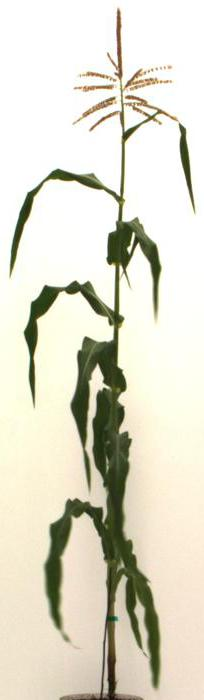

In [7]:
## Accedemos a una imagen aleatoria para comprobar que tenemos acceso

probar_imagen = os.path.join(ruta_imagenes, archivos_en_carpeta[0])

imagen = Image.open(probar_imagen)

display(imagen)

# Parte II preprocesamiento de las imágenes

In [8]:
!pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 23.2 MB/s eta 0:00:00


In [9]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio

### Dividimos el conjunto en subconjuntos para entrenamiento, validación y prueba

In [10]:
train_fraction = int(len(df_img)*0.8) #entrenamos con el 80% de los datos
test_fraction= int(len(df_img)*0.1) #probamos con el 10% de los datos
val_fraction= int(len(df_img)*0.1) #validamos con el 10% de los datos
train_dirs_dataset = tf.data.Dataset.from_tensor_slices((df_img[:train_fraction],etiquetas[:train_fraction]))
test_dirs_dataset = tf.data.Dataset.from_tensor_slices((df_img[train_fraction:(train_fraction+test_fraction)],etiquetas[train_fraction:(train_fraction+test_fraction)]))
val_dirs_dataset=tf.data.Dataset.from_tensor_slices((df_img[(train_fraction+test_fraction):(train_fraction+test_fraction+val_fraction)],etiquetas[(train_fraction+test_fraction):(train_fraction+test_fraction+val_fraction)]))

### Definimos el método que ajusta el tamaño de las imágenes para que puedan ser recibidas por el modelo

In [11]:
def LoadImages(dir_imagen, label_imagen):
    # Leer la imagen JPEG
    img = tf.image.decode_jpeg(tf.io.read_file(dir_imagen), channels=3)
    img = tf.image.resize(img, [224, 224], method=tf.image.ResizeMethod.AREA)
    img = tf.cast(img, dtype=tf.float64) / 255.0  # Escalar al rango [0, 1]
    img = (img * 2) - 1  # Normalizar entre -1 y 1

    label = tf.cast(label_imagen, dtype=tf.uint8)
    return img, label

In [12]:
train_dataset = train_dirs_dataset.map(LoadImages, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dirs_dataset.map(LoadImages, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = val_dirs_dataset.map(LoadImages, num_parallel_calls=tf.data.experimental.AUTOTUNE)

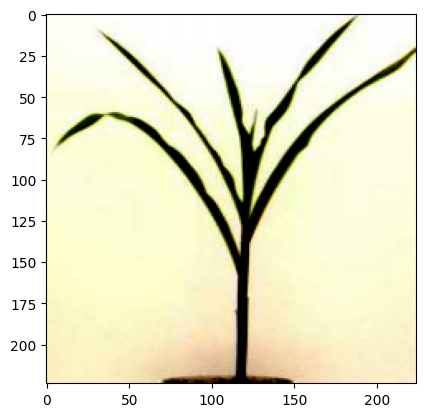

tf.Tensor([0 1 0 0 0 0], shape=(6,), dtype=uint8)


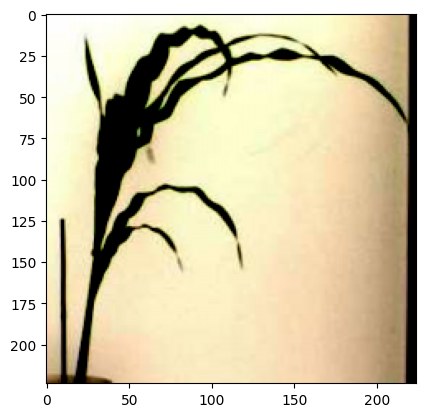

tf.Tensor([1 0 0 0 0 0], shape=(6,), dtype=uint8)


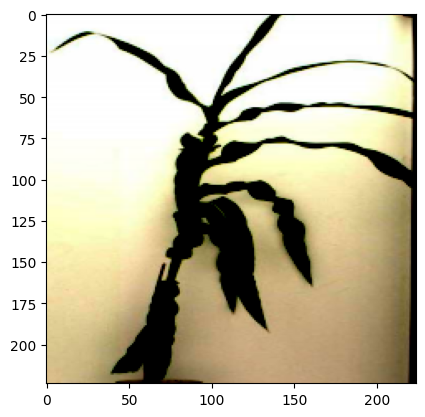

tf.Tensor([0 0 0 0 0 1], shape=(6,), dtype=uint8)


In [13]:
for imagen,label in validation_dataset.take(3):
  plt.imshow((imagen.numpy()))
  plt.show()
  print(label)

In [14]:
train_dataset

<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.uint8, name=None))>

# Parte 4 definimos el modelo: usamos transferlearning con el modelo VGG16, además hacemos fine-tuning entrenando las últimas 15 capas de este modelo
Este ejercicio se aborda como un problema de clasificación multiclase

In [15]:
import numpy as np
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.optimizers import SGD
from tensorflow.keras.metrics import Recall


In [16]:
# Cargar el modelo VGG16 con pesos preentrenados y excluir las capas de clasificación
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar todas las capas excepto las últimas 15
for layer in base_model.layers[:-15]:
    layer.trainable = False

# Crear un modelo secuencial y agregar el modelo base
model = tf.keras.models.Sequential()
model.add(base_model)

# Agregar capas personalizadas para la tarea específica, en este caso la última capa clasifica entre las 6 clase sposibles
# Usamos el parámetro de regularización L2
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model.add(tf.keras.layers.Dense(12, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

model.add(tf.keras.layers.Dense(6, activation='softmax'))


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', Recall()])

# Resumen del modelo
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 24)                602136    
                                                                 
 dense_1 (Dense)             (None, 12)                300       
                                                                 
 dense_2 (Dense)             (None, 6)                 78        
                                                                 
Total params: 15317202 (58.43 MB)
Trainable params: 15278482 (58.28 MB)
Non-trainable params: 38720 (151.25 KB)
___________

In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Definir el callback de parada temprana
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Definir el callback para guardar el mejor modelo
model_checkpoint = ModelCheckpoint('/content/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Definir el callback ReduceLROnPlateau, disminuye el valor del Learning Rate cada vez que la pérdida no mejore cada 3 épocas
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Combinar todos los callbacks
callbacks = [early_stopping, model_checkpoint, reduce_lr]




In [19]:
# Entrenar el modelo con los callbacks
history = model.fit(train_dataset.batch(64),validation_data=validation_dataset.batch(16),epochs=30,callbacks=callbacks)

Epoch 1/30
92/92 [==============================] - ETA: 0s - loss: 1.7028 - accuracy: 0.2928 - recall: 0.0225
Epoch 1: val_loss improved from inf to 1.55422, saving model to /content/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 117s 873ms/step - loss: 1.7028 - accuracy: 0.2928 - recall: 0.0225 - val_loss: 1.5542 - val_accuracy: 0.3542 - val_recall: 0.0599 - lr: 1.0000e-04
Epoch 2/30
92/92 [==============================] - ETA: 0s - loss: 1.5969 - accuracy: 0.3494 - recall: 0.0701
Epoch 2: val_loss improved from 1.55422 to 1.52136, saving model to /content/best_model.h5
92/92 [==============================] - 72s 781ms/step - loss: 1.5969 - accuracy: 0.3494 - recall: 0.0701 - val_loss: 1.5214 - val_accuracy: 0.3910 - val_recall: 0.0450 - lr: 1.0000e-04
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 1.5050 - accuracy: 0.3956 - recall: 0.0997
Epoch 3: val_loss improved from 1.52136 to 1.45042, saving model to /content/best_model.h5
92/92 [==============================] - 73s 791ms/step - loss: 1.5050 - accuracy: 0.3956 - recall: 0.0997 - val_loss: 1.4504 - val_accuracy: 0.4114 - val_recall: 0.0545 - lr: 1.0000e-04
Epoch 4/30
92/92 [================

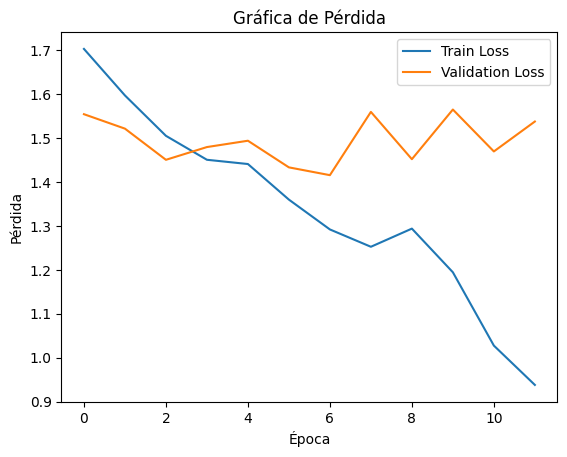

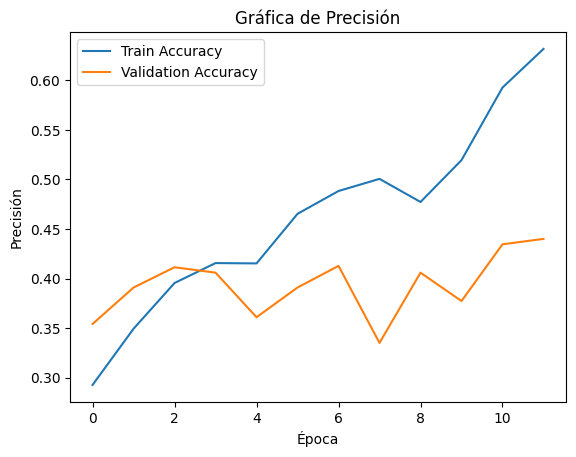

In [20]:
import matplotlib.pyplot as plt

# Gráfica de pérdida (loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Gráfica de Pérdida')
plt.show()

# Gráfica de precisión (accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.title('Gráfica de Precisión')
plt.show()

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [25]:
# Realizar predicciones en el conjunto de prueba
batch_size = 64  # este es el tamaño de bath que seleccionamos en el fit

# obtenemos las imágenes para el test
test_dataset = test_dirs_dataset.map(LoadImages, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)

# obtenemos las clases reales (estan en formato one-hot)
true_labels = np.concatenate([labels for _, labels in test_dataset])
# Convertir de one-hot encoding a enteros, ese + 7 es porque nuestras clases van de 7 a 12
true_labels_int = np.argmax(true_labels, axis=1) + 7

# obtenemos predicciones
predictions = model.predict(test_dataset, steps=len(test_dataset))
# le sumamos + 7 ya que las clases van de 7 a 12
predicted_labels = np.argmax(predictions, axis=1) + 7


12/12 [==============================] - 3s 299ms/step


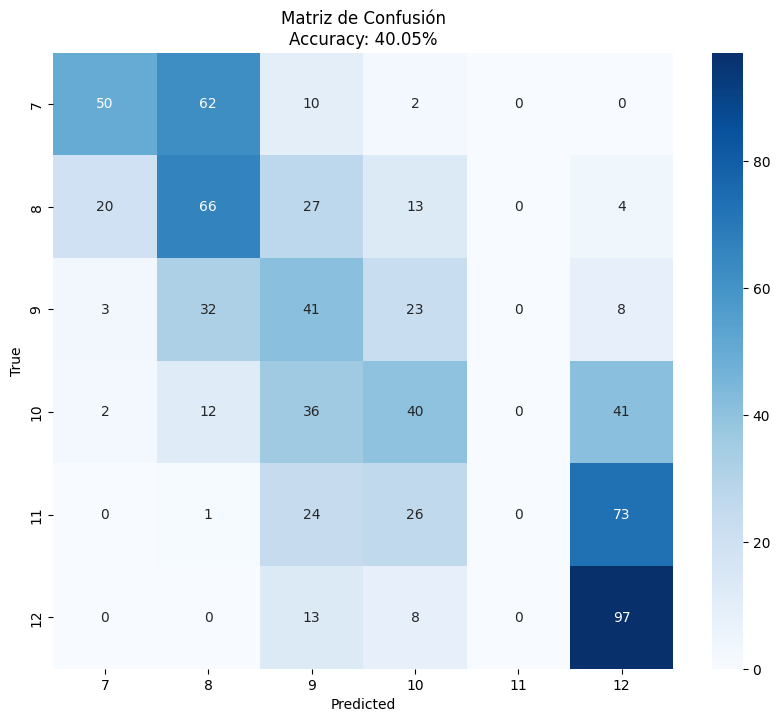

In [31]:
# definimos nuestro numero de clases
num_classes = 6


# Calculamos la matriz de confusión
conf_matrix = confusion_matrix(true_labels_int, predicted_labels)

# definimos los nombres de las clases
class_names = [7,8,9,10,11,12]

# Calculamos la precisión
accuracy = accuracy_score(true_labels_int, predicted_labels)

# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Matriz de Confusión\nAccuracy: {accuracy:.2%}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


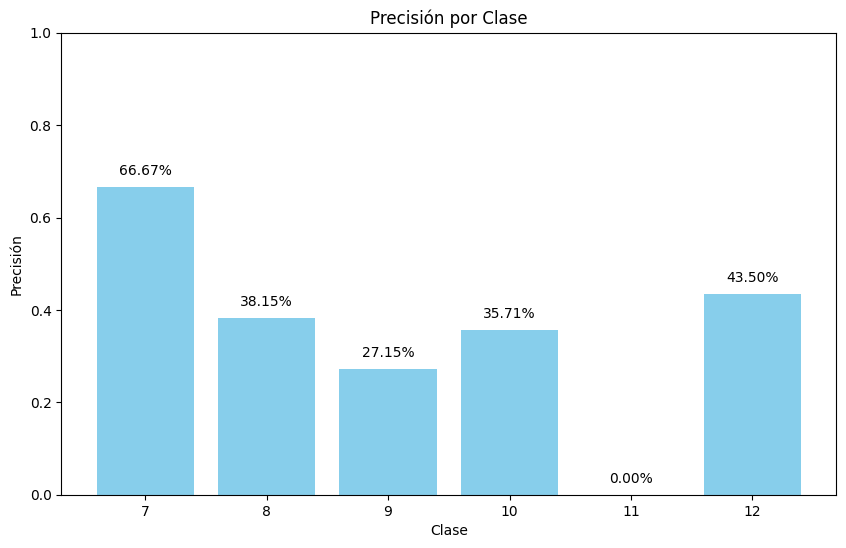

In [35]:
from sklearn.metrics import precision_score

# Calculamos la precisión por cada clase
precision_per_class = precision_score(true_labels_int, predicted_labels, average=None)
class_names = [7,8,9,10,11,12]

# Graficamos la precisión por cada clase
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, precision_per_class, color='skyblue')
plt.xlabel('Clase')
plt.ylabel('Precisión')
plt.title('Precisión por Clase')
plt.ylim(0, 1)

# Agregamos los valores del porcentaje en la parte superior de cada barra
for bar, precision in zip(bars, precision_per_class):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{precision:.2%}', ha='center', va='bottom')

plt.show()